In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model, Model
import cv2

1/1 [==============================] - 2s 2s/step


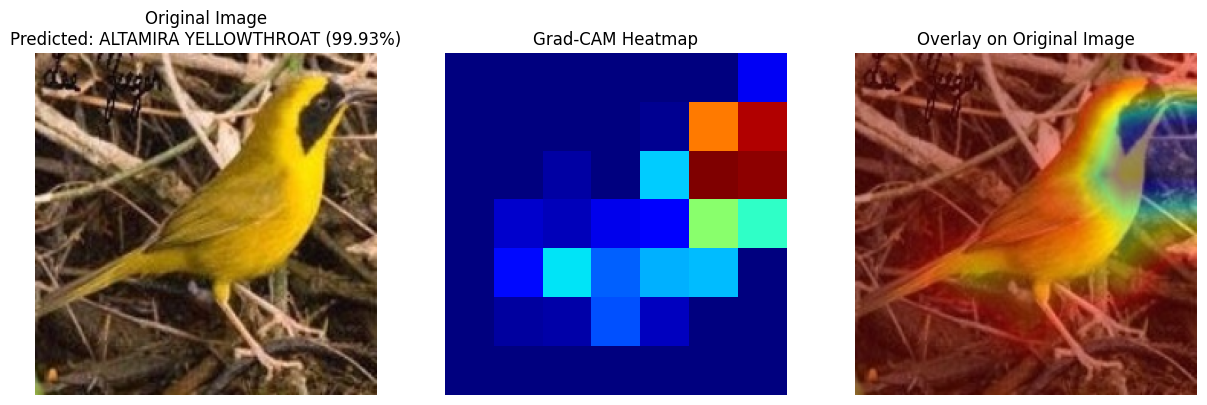

In [ ]:
img_path = '/content/drive/MyDrive/Colab/BigDataProject/BirdSpecies-20-Dataset/birdSpecies02/train/ALTAMIRA YELLOWTHROAT/001.jpg'
model_path = '/content/drive/MyDrive/Colab/BigDataProject/savedModels/bird-species-Resnet101V2-with-data-augumentation-trial01-03.h5'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model, Model
import cv2

class_names = {
    0: 'ABBOTTS BABBLER',
    1: 'ABBOTTS BOOBY',
    2: 'ABYSSINIAN GROUND HORNBILL',
    3: 'AFRICAN CROWNED CRANE',
    4: 'AFRICAN EMERALD CUCKOO',
    5: 'AFRICAN FIREFINCH',
    6: 'AFRICAN OYSTER CATCHER',
    7: 'AFRICAN PIED HORNBILL',
    8: 'AFRICAN PYGMY GOOSE',
    9: 'ALBATROSS',
    10: 'ALBERTS TOWHEE',
    11: 'ALEXANDRINE PARAKEET',
    12: 'ALPINE CHOUGH',
    13: 'ALTAMIRA YELLOWTHROAT',
    14: 'AMERICAN AVOCET',
    15: 'AMERICAN BITTERN',
    16: 'AMERICAN COOT',
    17: 'AMERICAN FLAMINGO',
    18: 'AMERICAN GOLDFINCH',
    19: 'AMERICAN KESTREL'
}

class GradCAM:
    def __init__(self, model, class_idx, layer_name=None):
        self.model = model
        self.class_idx = class_idx
        self.layer_name = layer_name
        if self.layer_name is None:
            self.layer_name = self.find_last_conv_layer()

    def find_last_conv_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name

    def generate_cam(self, img_array):
        grad_model = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, self.class_idx]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

        heatmap = tf.maximum(cam, 0)
        max_heat = tf.reduce_max(heatmap)
        if max_heat == 0:
            max_heat = 1e-10
        heatmap /= max_heat

        return heatmap.numpy()

    def overlay_heatmap(self, heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
        superimposed_img = heatmap * alpha + image * (1 - alpha)
        superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
        return superimposed_img

#model
model = load_model(model_path)
#image preprocess
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_array_expanded = img_array_expanded / 255.0 ]
#model predictions and generate CAM
preds = model.predict(img_array_expanded)
class_idx = np.argmax(preds[0])
probability = np.max(preds[0]) * 100
predicted_class_name = class_names[class_idx]
cam_generator = GradCAM(model, class_idx, "conv5_block3_out")
heatmap = cam_generator.generate_cam(img_array_expanded)
superimposed_img = cam_generator.overlay_heatmap(heatmap, img_array)
#GradCam plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_array / 255.0)
ax[0].set_title(f"Original Image\nPredicted: {predicted_class_name} ({probability:.2f}%)")
ax[0].axis('off')
ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')
ax[2].imshow(superimposed_img / 255.0)
ax[2].set_title("Overlay on Original Image")
ax[2].axis('off')
plt.show()